In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# Project-3. Прогнозирование рейтинга отеля на Booking
*Цель:* создать модель, которая должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

*Задача:* Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

Описание данных:

*Связанные с отелем признаки / Hotel Related Features (7)*

* hotel_name - full hotel name - название отеля;

* hotel_address - address: street, post code, city, country - адрес отеля;

* lat - hotel latitude coordinate - широта отеля;

* lng - hotel longitude coordinate - долгота отеля;

* average_score - average hotel rating -средний балл отеля, рассчитанный на основе последнего комментария за последний год;

* total_number_of_reviews - total number of hotel reviews - общее количество действительных отзывов об отеле;

* additional_number_of_scoring - number of hotel scores without review - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

*Связанные с рецензентом признаки / Reviewer Related Features (3)*

* reviewer_nationality - reviewer nationality - национальность рецензента;

* total_number_of_reviews_reviewer_has_given - total number of reviews reviewer has given - количество отзывов, которые рецензенты дали в прошлом;

* tags - tags describing stay in the hotel - теги, которые рецензент дал отелю.

*Связанные с отзывом признаки / Review Related Features (7)*

* review_date - date of review - дата, когда рецензент разместил соответствующий отзыв;

* days_since_review - difference in the number of days between review date and scrape date - продолжительность между датой проверки и датой очистки;

* negative_review - text of negative review - отрицательный отзыв, который рецензент дал отелю;

* review_total_negative_word_counts - negative review words number - общее количество слов в отрицательном отзыв;

* positive_review - text of positive review - положительный отзыв, который рецензент дал отелю;

* review_total_positive_word_counts - positive review words number - общее количество слов в положительном отзыве;

* reviewer_score - rating given by the reviewer to the hotel based on their experience - оценка, которую рецензент поставил отелю на основе своего опыта.

Загружаем библиотеки и инструменты

In [2]:
!pip install geopy
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=9dd9d945965801c5f0ea2a1fd9a29e5b042ebddce4becd93ae3cc58070c8492e
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
%matplotlib inline
import category_encoders as ce
import re

from matplotlib import ticker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
from scipy import stats
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import squarify

from geopy.geocoders import Nominatim
from geopy.geocoders import Yandex
import geopy.distance
from geopy import distance

from datetime import datetime as dt


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Воспроизводимость кода

In [4]:
# Фиксируем сид для воспроизводимости кода
RANDOM_SEED = 42

In [5]:
# Фиксируем версии пакетов для воспроизводимости кода
!pip freeze > requirements.txt

## 1. Загрузка данных / Loading Data

In [6]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

**Предварительное исследование данных**

Посмотрим какие данные имеются в датасете, сколько пустых значений в признаках и какие типы данных мы имеем.

In [7]:
display(df_train.head(3))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [9]:
display(df_test.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [11]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


## 2. Проектирование признаков

Для синхронного преобразования признаков объединим датасеты в один, создавая при этом метку-разделитель, чтобы после преобразований разделить тренировочные данные и тестовые.

In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], axis='index', ignore_index=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [15]:
# Создание временного логического признака 'lost_hotel'
# (где координаты отсутствуют)
data['lost_hotel'] = data.lat.isna()

print(f'{data.hotel_address.nunique()} уникальных адресов отелей')
print(f'{data.lng.nunique()} уникальной долготы')
print(f'{data.lat.nunique()} уникальной широты')
print(f'{data[data.lost_hotel].hotel_address.nunique()} отелей без координат')

1493 уникальных адресов отелей
1472 уникальной долготы
1472 уникальной широты
17 отелей без координат


Итог, у нас всего 1493 отеля. Для них есть 1472 уникальных координат и всего 17 отелей без координат (далее — «потерянные отели», lost_hotel). Возможно, ещё у 4 отелей координаты могут совпадать с другими.

Проанализируем структуру содержимого hotel_address:

In [16]:
for str_ in data.hotel_address[:10]:
    print(str_)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


Итак, посчитаем число стран и городов, встречающихся во всех адресах:

Страна - это последнее слово адреса, в случае Соединенного Королевства - последние два слова. Город - это второе слово с конца, в случае Соединенного Королевства - пятое слово с конца.

In [17]:
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1]\
                                            if x.split()[-1] != 'Kingdom'\
                                                    else ' '.join(x.split()[-2:]))

print('В наборе данных представлены отели из '+str(data['country'].nunique())+' разных стран.\n')
print(data['country'].value_counts())

data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2]\
                                         if x.split()[-1] != 'Kingdom'\
                                         else x.split()[-5])

print('\nВ наборе данных представлены отели из '+str(data['city'].nunique())+' разных городов.\n')
print(data['city'].value_counts())

В наборе данных представлены отели из 6 разных стран.

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

В наборе данных представлены отели из 6 разных городов.

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64


In [18]:
def chart_column_treemap(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    title_fontsize=14,   # title font size
    size=[8, 4]):        # size of the chart

    grouped = df.groupby(col).size().sort_values(ascending=False).reset_index(name='Counts')
    labels = grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = grouped['Counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

    plt.figure(figsize=(size[0], size[1]), dpi= 80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    plt.title(title, size=title_fontsize)
    plt.axis('off')
    plt.show();

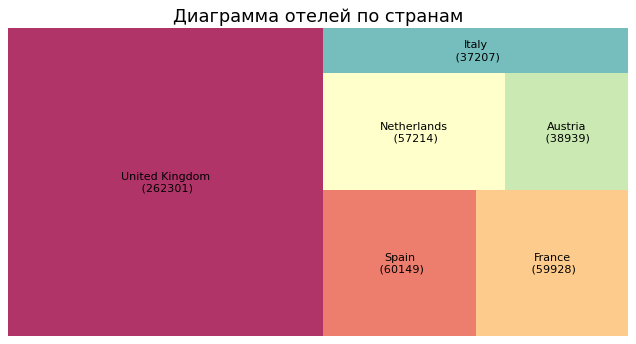

In [19]:
chart_column_treemap(
    data,
    'country',
    'Диаграмма отелей по странам',
    title_fontsize=16,
    size=[10, 5])

In [20]:
data[pd.isnull(data['lat'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3268 entries, 122 to 515616
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   hotel_address                               3268 non-null   object 
 1   additional_number_of_scoring                3268 non-null   int64  
 2   review_date                                 3268 non-null   object 
 3   average_score                               3268 non-null   float64
 4   hotel_name                                  3268 non-null   object 
 5   reviewer_nationality                        3268 non-null   object 
 6   negative_review                             3268 non-null   object 
 7   review_total_negative_word_counts           3268 non-null   int64  
 8   total_number_of_reviews                     3268 non-null   int64  
 9   positive_review                             3268 non-null   object 
 10  review_t

In [21]:
mask = (data['lat'].isnull() == True)|(data['lng'].isnull() == True)
print('Количество отелей без координат:', data[mask]['hotel_name'].value_counts().count())

Количество отелей без координат: 17


Так как всего у 17 отелей пропущены широта и долгота, то не имеет смысла подгружать данные из внешних источников, проще и быстрее будет заполнить вручную. Создадим словарь, где ключом является название+адрес отеля, а значением список из широты и долготы.

In [22]:
# Для читаемости кода создадим список названий+адресов отелей, в которых есть пропуски координат
lat_lng_less = data[mask]['hotel_name'].value_counts()
lat_lng_less

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: hotel_name, dtype: int64

In [23]:
# Словарь, где ключ - название+адрес отеля, значение - список[широта, долгота]
hotels_nowhere = {
    lat_lng_less.index[0]:[48.2094018,16.3534456],
    lat_lng_less.index[1]:[48.213587,16.3773333],
    lat_lng_less.index[2]:[48.2204104,16.3532437],
    lat_lng_less.index[3]:[48.8753173,2.3208171],
    lat_lng_less.index[4]:[48.1888148,16.3812044],
    lat_lng_less.index[5]:[48.2167996,16.3573308],
    lat_lng_less.index[6]:[48.2195694,16.2830172],
    lat_lng_less.index[7]:[48.2458873,16.339354],
    lat_lng_less.index[8]:[41.391548,2.1753191],
    lat_lng_less.index[9]:[48.2208519,16.3640366],
    lat_lng_less.index[10]:[48.2205671,16.2152523],
    lat_lng_less.index[11]:[48.2095489,16.3488884],
    lat_lng_less.index[12]:[48.8889092,2.3305781],
    lat_lng_less.index[13]:[48.2227607,16.3909124],
    lat_lng_less.index[14]:[48.8377262,2.3159061],
    lat_lng_less.index[15]:[41.3926849,2.1648227],
    lat_lng_less.index[16]:[41.3832385,2.1603747]
    }

In [24]:
# заполняем пустые значения координат отелей на 0, для удобства отсеивания по условию
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

In [25]:
# Функция для заполнения широты, принимает название_адрес отеля и широту, возвращает обновленную широту
def full_lat(hotel_name, lat):
    if lat == 0:
        if hotel_name in hotels_nowhere:
            lat = hotels_nowhere[hotel_name][0]
    return lat

data['lat'] = data.apply(lambda x: full_lat(x['hotel_name'], x['lat']), axis=1)

# Функция для заполнения долготы, принимает название_адрес отеля и долготу, возвращает обновленную долготу
def full_lat(hotel_name, lng):
    if lng == 0:
        if hotel_name in hotels_nowhere:
            lng = hotels_nowhere[hotel_name][1]
    return lng

data['lng'] = data.apply(lambda x: full_lat(x['hotel_name'], x['lng']), axis=1)


Избавляемся от признаков lost_hotel:

In [26]:
data.drop(columns=['lost_hotel'], inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Теперь у нас нет пропусков в датасете, координаты всех отелей в наличии.

Создаем словарь географических параметров городов - для каждого города:

* координаты центра / center coordinates;
* население в миллионах / population in million;
* площадь/ area in km2;
* условный радиус / radius in km.

In [28]:
# Для каждого города: [center_lat, center_lng, population, area in km2, radius in km]
# Данные взяты: https://dateandtime.info and Wiki in May 2023

cities_dictionary = {
    'Paris'    : [48.8534100, 2.3488000, 2,102650, 105.4, 5.792],
    'London'   : [51.5085300, -0.1257400, 8.799800, 1572, 22.582],
    'Barcelona': [41.3887900, 2.1589900, 1.621537 , 101.4, 8.031],
    'Milan'    : [45.4642700, 9.1895100, 1.371498, 181.76, 7.604],
    'Vienna'   : [48.2084900, 16.3720800, 1.951354, 414.78, 11.49],
    'Amsterdam': [52.3740300, 4.8896900, 1.459402, 219.32, 8.807],
}

Создаем новый столбец - расстояние от центра.

In [29]:
def distance_to_center(city, lat, lng):
    return geopy.distance.geodesic([cities_dictionary[city][0], 
                                    cities_dictionary[city][1]],
                                   [lat, lng]).km

data['distance'] = data.apply(lambda x:
                                  distance_to_center(x.city, x.lat, x.lng), 
                                  axis = 1)

Создаем колонку 'proximity' как отношение расстояния до центра к условному радиусу

In [30]:
data['proximity'] = data.apply(lambda x: x['distance']/cities_dictionary[x['city']][-1],
                                   axis=1)

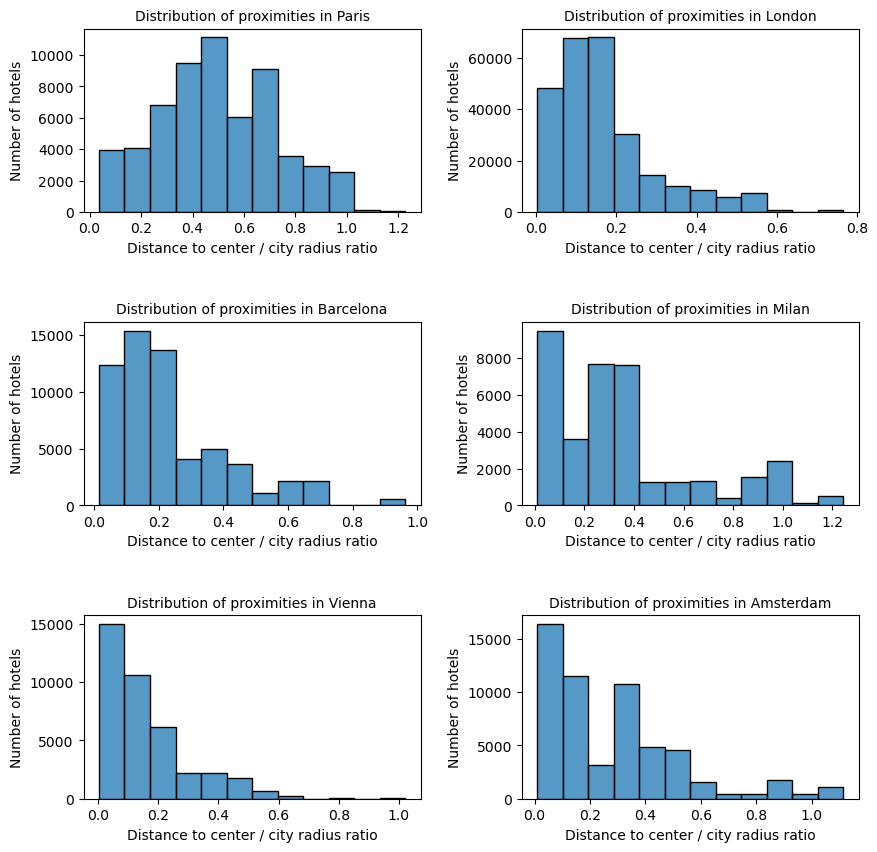

In [31]:
bins_number = 12
font = 10
x_label = 'Distance to center / city radius ratio'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=.6, wspace=.3)

histplot_par = sns.histplot(data=data[data.city == 'Paris'], 
                            x='proximity', bins=bins_number, ax=axes[0,0])
histplot_par.set_title('Distribution of proximities in Paris', fontsize=font)
histplot_par.set_xlabel(x_label)
histplot_par.set_ylabel('Number of hotels')

histplot_lon = sns.histplot(data=data[data.city == 'London'],
                            x='proximity', bins=bins_number, ax=axes[0,1])
histplot_lon.set_title('Distribution of proximities in London', fontsize=font)
histplot_lon.set_xlabel(x_label)
histplot_lon.set_ylabel('Number of hotels')

histplot_bar = sns.histplot(data=data[data.city == 'Barcelona'],
                            x='proximity', bins=bins_number, ax=axes[1,0])
histplot_bar.set_title('Distribution of proximities in Barcelona', fontsize=font)
histplot_bar.set_xlabel(x_label)
histplot_bar.set_ylabel('Number of hotels')

histplot_mil = sns.histplot(data=data[data.city == 'Milan'],
                            x='proximity', bins=bins_number, ax=axes[1,1])
histplot_mil.set_title('Distribution of proximities in Milan', fontsize=font)
histplot_mil.set_xlabel(x_label)
histplot_mil.set_ylabel('Number of hotels')

histplot_vie = sns.histplot(data=data[data.city == 'Vienna'],
                            x='proximity', bins=bins_number, ax=axes[2,0])
histplot_vie.set_title('Distribution of proximities in Vienna', fontsize=font)
histplot_vie.set_xlabel(x_label)
histplot_vie.set_ylabel('Number of hotels')

histplot_ams = sns.histplot(data=data[data.city == 'Amsterdam'],
                            x='proximity', bins=bins_number, ax=axes[2,1])
histplot_ams.set_title('Distribution of proximities in Amsterdam', fontsize=font)
histplot_ams.set_xlabel(x_label)
histplot_ams.set_ylabel('Number of hotels');

In [32]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_score,tags,days_since_review,lat,lng,sample,country,city,distance,proximity
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1,United Kingdom,London,1.246901,0.055217
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1,United Kingdom,London,1.400409,0.062014


Количество отзывов / Number of reviews

Смотрим на статистику и распределение.

In [33]:
data.total_number_of_reviews.describe()

count    515738.000000
mean       2743.743944
std        2317.464868
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3613.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

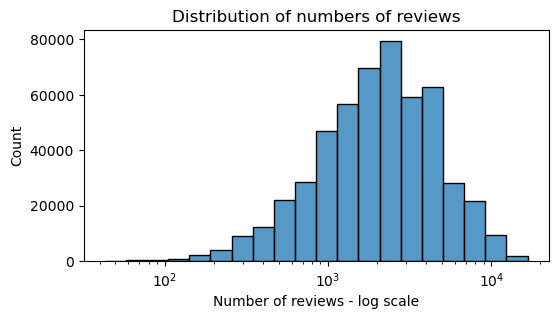

In [34]:
bins_number = 20
font = 12

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.subplots_adjust(hspace=.25)

histplot_par = sns.histplot(data=data, 
                            x='total_number_of_reviews', bins=bins_number, log_scale=True)
histplot_par.set_title('Distribution of numbers of reviews', fontsize=font)
histplot_par.set_xlabel('Number of reviews - log scale')
histplot_par.set_ylabel('Count');

Похоже на логнормальное распределение. Оставим все как есть.

Средний балл отеля / Hotel score

Смотрим на статистику и распределение.

In [35]:
data.average_score.describe()

count    515738.000000
mean          8.397487
std           0.548048
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

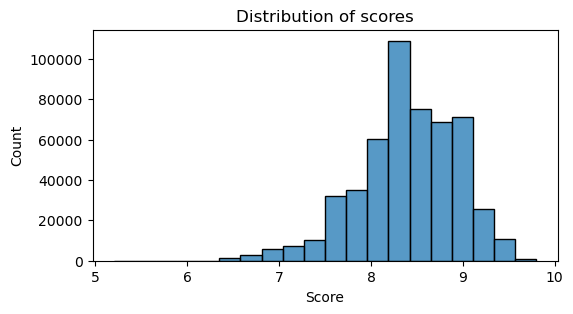

In [36]:
bins_number = 20
font = 12

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.subplots_adjust(hspace=.25)

histplot_par = sns.histplot(data=data, 
                            x='average_score', bins=bins_number)
histplot_par.set_title('Distribution of scores', fontsize=font)
histplot_par.set_xlabel('Score')
histplot_par.set_ylabel('Count');

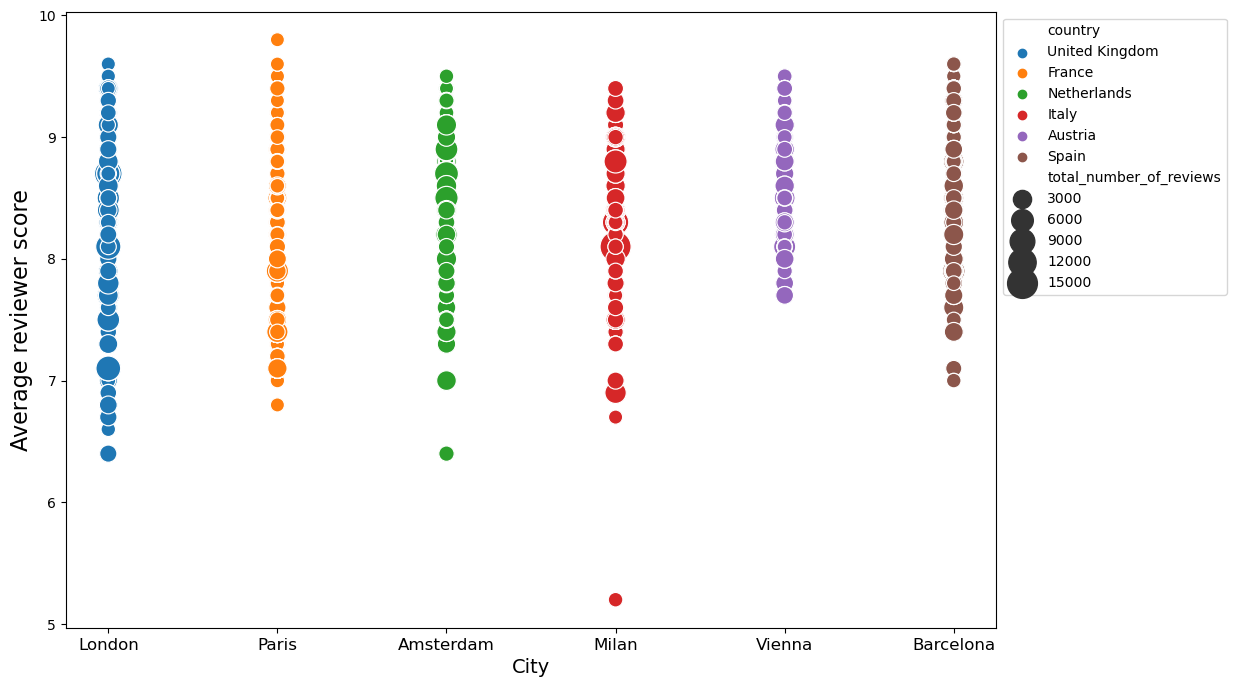

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# use the scatterplot function to build the bubble map
sns.scatterplot(data=data, 
                x='city',
                y='average_score',
                hue='country',
                size='total_number_of_reviews', 
                legend=True, sizes=(100, 500))

plt.xlabel('City', fontsize=14)
plt.ylabel('Average reviewer score', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tick_params(axis='x', labelsize= 12 ) 

# show the graph
plt.show()

Из графика видно, что отзывы распределяются от 7 до 9,5 баллов по всем городам.

Оценки по странам / Reviewer score vs. country

In [40]:
grouped = data.groupby('country')['average_score'].agg(['mean', 'median', 'count'])

grouped

,mean,median,count
country,,,
Austria,8.558034,8.5,38939
France,8.409053,8.5,59928
Italy,8.426729,8.4,37207
Netherlands,8.387085,8.4,57214
Spain,8.522812,8.5,60149
United Kingdom,8.340393,8.4,262301


Лучшие оценки, у отелей Австрии, Нидерланд и Испании, самые низкие - Франции, Италии и Великобритании.

Заключение по отелям / Conclusions on hotels

Мы:

* получили информацию о стране/городе по адресам;
* заполнили недостающие значения широты/lng с помощью geopy geolocator;
* создали столбцы расстояния и близости к центру.

Национальность рецензента / Reviewer nationality

In [42]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda s: s.strip())

print('There are '+str(data['reviewer_nationality'].nunique())+' different reviewers nationalities in the dataset.\n')
data['reviewer_nationality'].value_counts(normalize=True).head(12)

There are 227 different reviewers nationalities in the dataset.



United Kingdom              0.475524
United States of America    0.068711
Australia                   0.042048
Ireland                     0.028749
United Arab Emirates        0.019845
Saudi Arabia                0.017356
Netherlands                 0.017009
Switzerland                 0.016826
Germany                     0.015397
Canada                      0.015306
France                      0.014147
Israel                      0.012817
Name: reviewer_nationality, dtype: float64

Добавим колонку local_reviewer: '1' если национальность рецензента и страна отеля совпадают, в противном случае '0'.

In [43]:
data['local_reviewer'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)

data['local_reviewer'].value_counts(normalize=True)

0    0.654082
1    0.345918
Name: local_reviewer, dtype: float64

Примерно 1/3 отзывов от местных рецензентов и 2/3 от иностранцев.

Уменьшим количество категорий до N наиболее частых и 'Other'.

In [45]:
def reduce_categories_number(df, col, n):
    '''
    Функция принимает датасет df, колонку col и n - количество наиболее частых категорий.
    Категории не входящие в n наиболее частых заменяются на 'Other'.
    Функция возвращает полученный датасет.
    '''
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else 'Other')
    return df

data = reduce_categories_number(data, 'reviewer_nationality', 11)

Add 'reviewer_swl' column - [Satisfaction with Life Index](https://en.wikipedia.org/wiki/Satisfaction_with_Life_Index).

In [46]:
# Data from https://en.wikipedia.org/wiki/Satisfaction_with_Life_Index
swl_df = pd.DataFrame([['United Kingdom', 236.67],
                       ['United States of America', 246.67],
                       ['Australia', 243.33],
                       ['Ireland', 253.33],
                       ['United Arab Emirates', 246.67],
                       ['Saudi Arabia', 243.33],
                       ['Netherlands', 250],
                       ['Switzerland', 273.33],
                       ['Germany', 240],
                       ['Canada', 253.33],
                       ['France', 240],
                       ['Israel', 223.33],
                       ['Turkey', 176.67],
                       ['Spain', 233.33],
                       ['Other', 247.88], ], 
                      columns=['country', 'swl'])

In [47]:
data = data.join(swl_df.set_index('country'), on='reviewer_nationality')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

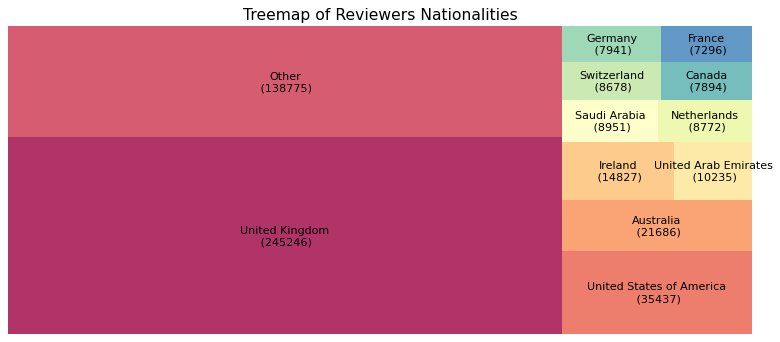

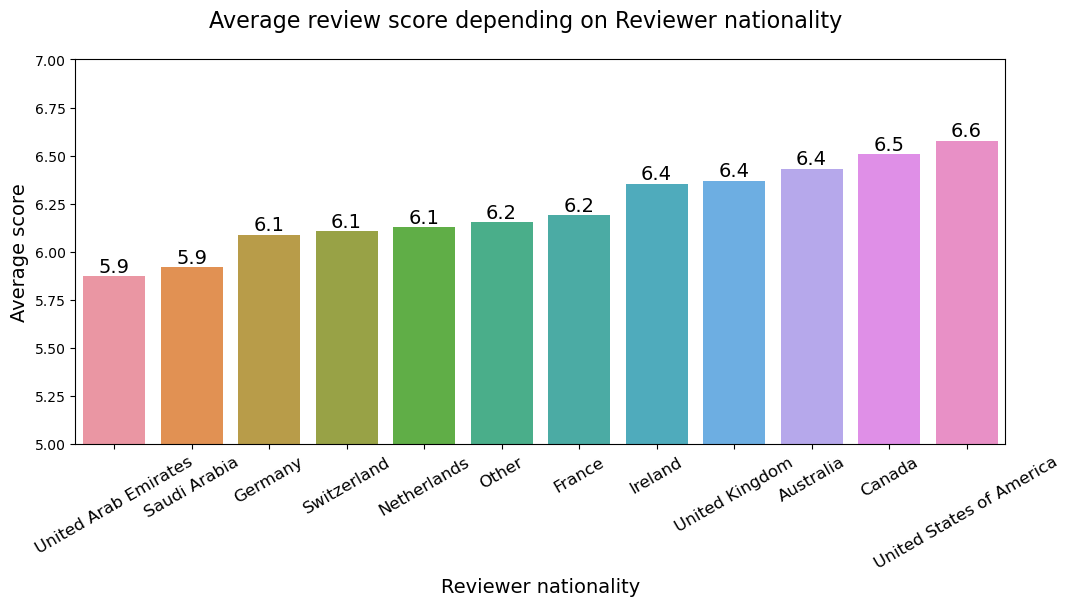

In [49]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'reviewer_nationality', 
                     'Treemap of Reviewers Nationalities', size=[12, 5])

def chart_score_vs_column(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    xlabel,              # X axis label
    ylabel,              # Y axis label

    size=[10, 5],        # size of the chart
    ylim=[5, 7],         # min/max of Y axis

                         # font sizes of:
    title_fontsize=16,   # title
    ticks_fontsize=12,   # ticks
    xlabel_fontsize=14,  # X axis label
    xticks_rotation=0,   # xticks rotation 
    ylabel_fontsize=14): # Y axis label
    
    grouped = df.groupby(col)['reviewer_score'].agg(['mean']).sort_values('mean')

    fig, ax = plt.subplots(figsize=(size[0], size[1]))

    plt.suptitle(title, size=title_fontsize)
    bar_types = sns.barplot(x=grouped.index, y=grouped['mean'])

    for p in bar_types.patches:
        bar_types.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.4, p.get_height()),
        ha='center', va='bottom', fontsize=int((title_fontsize+ticks_fontsize)/2))

    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(xlabel, size=xlabel_fontsize)
    plt.ylabel(ylabel, size=ylabel_fontsize)
    plt.xticks(fontsize=ticks_fontsize)
    plt.xticks(rotation=xticks_rotation);

chart_score_vs_column(data, 'reviewer_nationality', 
                      'Average review score depending on Reviewer nationality', 
                      'Reviewer nationality', 
                      'Average score', 
                      size=[12, 5], ylim=[5, 7], xticks_rotation=30)

Большинство рецензентов англоговорящие из USA, Canada, Australia, UK, Ireland. Они же ставят самые высокие оценки. Из арабских стран ставят самые низкие оценки. Европейские страны посередине.

Количество отзывов рецензента / Number of reviews from a reviewer

In [51]:
data['total_number_of_reviews_reviewer_has_given'].value_counts().head(10)

1     154640
2      67077
3      46845
4      35026
5      27629
6      22621
7      18614
8      16150
9      13545
10     11717
Name: total_number_of_reviews_reviewer_has_given, dtype: int64

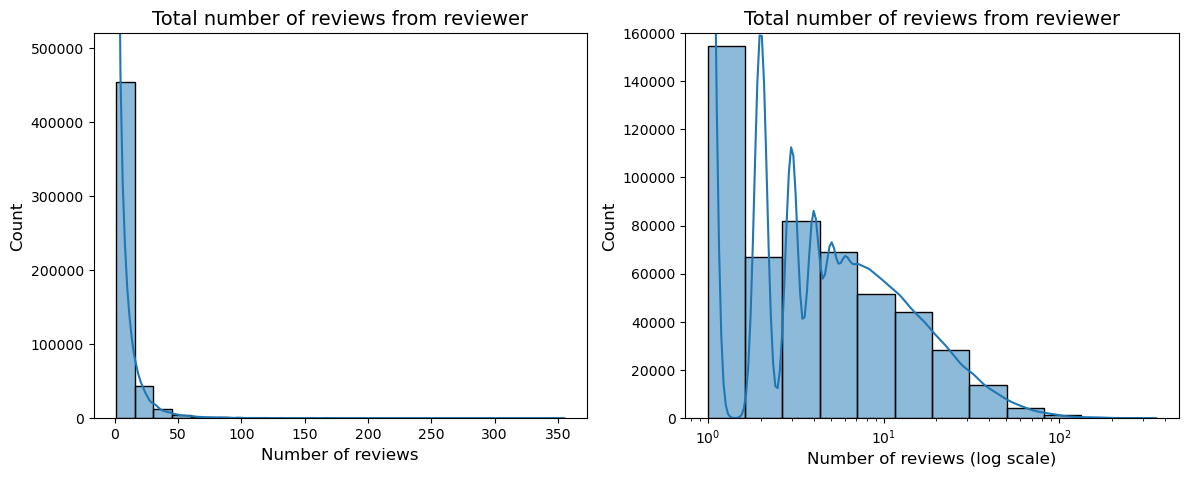

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
plt.subplots_adjust(hspace=.25)

histplot1 = sns.histplot(data=data, x='total_number_of_reviews_reviewer_has_given', 
                         bins=24, kde=True, log_scale=False, ax=axes[0])

histplot1.set_title('Total number of reviews from reviewer', fontsize=14)
histplot1.set_xlabel('Number of reviews', fontsize=12)
histplot1.set_ylabel('Count', fontsize=12);

histplot2 = sns.histplot(data=data, x='total_number_of_reviews_reviewer_has_given', 
                         bins=12, kde=True, log_scale=True, ax=axes[1])

histplot2.set_title('Total number of reviews from reviewer', fontsize=14)
histplot2.set_xlabel('Number of reviews (log scale)', fontsize=12)
histplot2.set_ylabel('Count', fontsize=12)

histplot1.axes.set_ylim(0, 520000)
histplot2.axes.set_ylim(0, 160000);

Похоже на логнормальное распределение.

"Очищаем" теги / Cleaning tags

Clean tags - get tags list, add 'number_of_tags' column Remove square brackets, replace "' " and " '" with "", split with ', ' as separator.

In [53]:
data['tags'] = data['tags'].apply(lambda s: s[1:] if s[0] == '[' else s)
data['tags'] = data['tags'].apply(lambda s: s[:-1] if s[-1] == ']' else s)

data['tags'] = data['tags'].apply(lambda s: s.replace('\' ', ''))
data['tags'] = data['tags'].apply(lambda s: s.replace(' \'', ''))

data['tags_list'] = data['tags'].apply(lambda s: s.split(', '))

data['number_of_tags'] = data['tags_list'].apply(len)

data['number_of_tags'].value_counts(normalize=True)

5    0.577470
4    0.410216
3    0.010674
6    0.001464
2    0.000165
1    0.000012
Name: number_of_tags, dtype: float64

In [54]:
display(data['tags'].head())
display(data['tags_list'].head())

0    Leisure trip, Couple, Studio Suite, Stayed 2 n...
1    Business trip, Couple, Standard Double Room, S...
2    Leisure trip, Solo traveler, Modern Double Roo...
3    Leisure trip, Solo traveler, Standard Room wit...
4    Business trip, Couple, Standard Double or Twin...
Name: tags, dtype: object

0    [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1    [Business trip, Couple, Standard Double Room, ...
2    [Leisure trip, Solo traveler, Modern Double Ro...
3    [Leisure trip, Solo traveler, Standard Room wi...
4    [Business trip, Couple, Standard Double or Twi...
Name: tags_list, dtype: object

После быстрого анализа тегов можем предположить следующее:

используется максимум 6 тегов;

* есть двоичные теги - 'With a pet' и 'Submitted from a mobile device'. Их можно кодировать с помощью 1 и 0;
* есть тег, который описывает тип поездки - Leisure/Business поездка;
* есть тег, описывающий, кто путешествует - Solo, Group, Couple or Family;
* есть тег, описывающий продолжительность пребывания, например, 'Stayed 7 nights';
* есть тег, описывающий различные типы комнат.

Tag 1. С животными / With a pet

In [55]:
def with_pet(tags_list):
    for element in tags_list:
        if 'With a pet' in element:
            return 1
    return 0

data['with_a_pet'] = data['tags_list'].apply(with_pet)

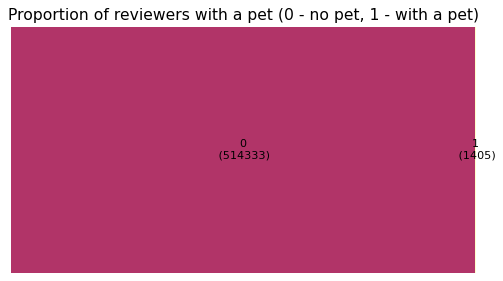

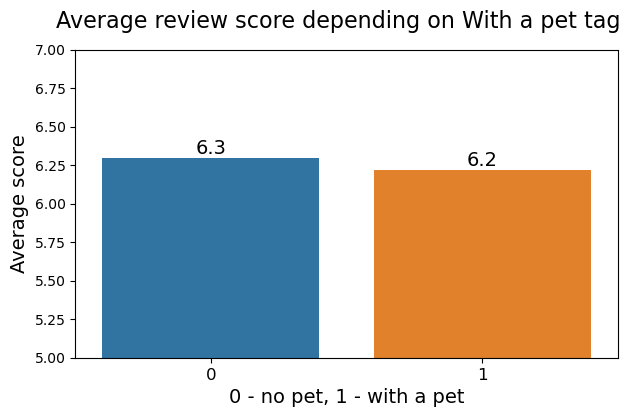

In [56]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'with_a_pet', 
                     'Proportion of reviewers with a pet (0 - no pet, 1 - with a pet)', size=[7.5, 4])

chart_score_vs_column(data, 'with_a_pet', 
                      'Average review score depending on With a pet tag', 
                      '0 - no pet, 1 - with a pet', 
                      'Average score', 
                      size=[7, 4], ylim=[5, 7])

Существует очень небольшая разница между средними и медианными оценками рецензентов с домашними животными и без них. Учитывая небольшое количество путешественников с домашними животными, мы не ожидаем, что эта функция окажется полезной для нашей модели.

Tag 2. Submitted from a mobile device

In [57]:
def from_mobile(tags_list):
    for element in tags_list:
        if 'Submitted from a mobile device' in element:
            return 1
    return 0

data['from_mobile'] = data['tags_list'].apply(from_mobile)

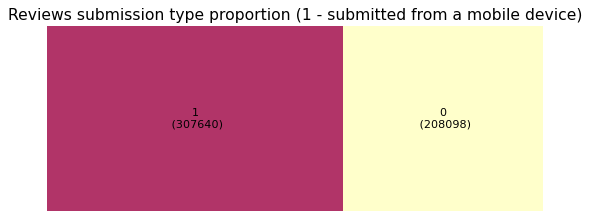

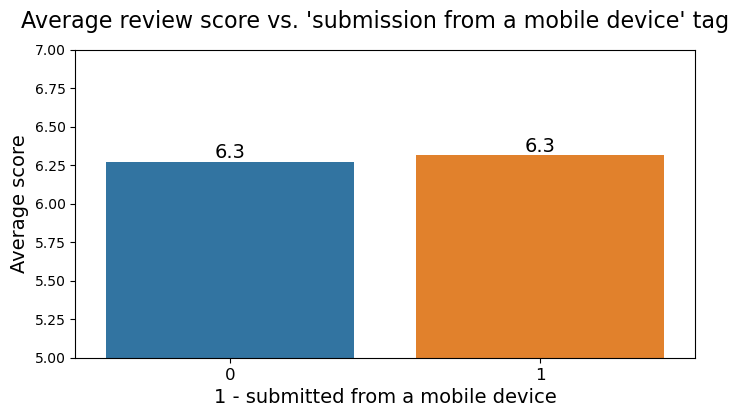

In [58]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'from_mobile', 
                     'Reviews submission type proportion (1 - submitted from a mobile device)', size=[8, 3])

chart_score_vs_column(data, 'from_mobile', 
                      'Average review score vs. \'submission from a mobile device\' tag', 
                      '1 - submitted from a mobile device', 
                      'Average score', 
                      size=[8, 4], ylim=[5, 7])

Оценки полученные с мобильных устройств немного выше остальных.

Tag 3. Trip type

In [59]:
# Returns trip type
def get_trip_type(tags_list):
    for element in tags_list:
        if 'trip' in element:
            return element
    return 'Unknown'

data['trip_type'] = data['tags_list'].apply(get_trip_type)

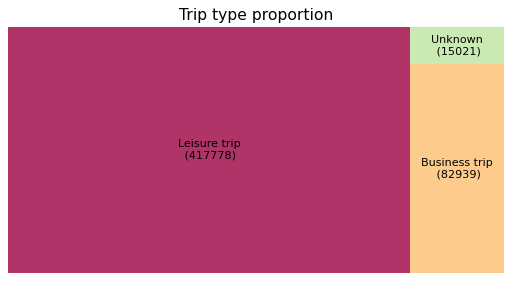

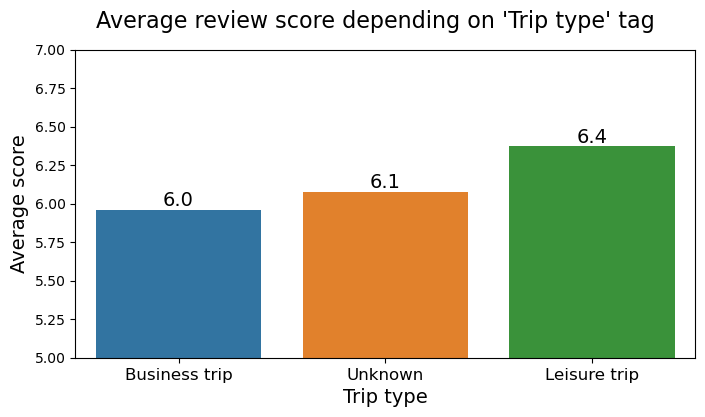

In [60]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'trip_type', 
                     'Trip type proportion', size=[8, 4])

chart_score_vs_column(data, 'trip_type', 
                      'Average review score depending on \'Trip type\' tag', 
                      'Trip type', 
                      'Average score', 
                      size=[8, 4], ylim=[5, 7])

Tag 4. Traveller type

In [61]:
def get_traveller_type(tags_list):
    for element in tags_list:
        if 'Solo' in element:
            return 'Solo'
        elif 'Group' in element:
            return 'Group'
        elif 'Couple' in element:
            return 'Couple'
        elif 'Family' in element:
            return 'Family'
    return 'Other'

data['traveller_type'] = data['tags_list'].apply(get_traveller_type)

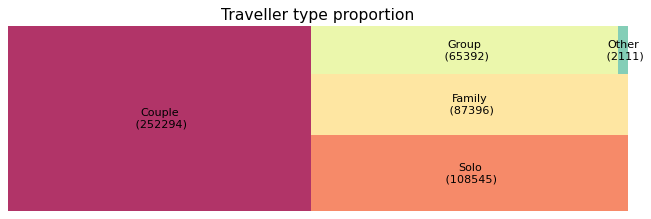

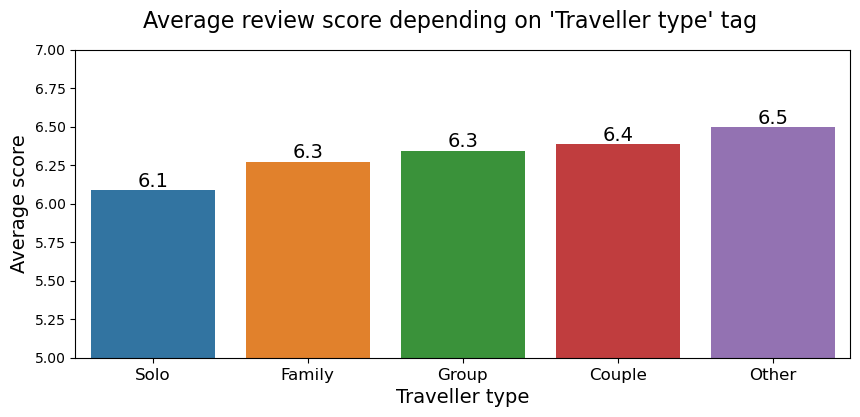

In [62]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'traveller_type', 
                     'Traveller type proportion', size=[10, 3])

chart_score_vs_column(data, 'traveller_type', 
                      'Average review score depending on \'Traveller type\' tag', 
                      'Traveller type', 
                      'Average score', 
                      size=[10, 4], ylim=[5, 7])

Итог: Одинокие путешественники ставят самые низкие оценки.

Tag 5. Length of stay

In [63]:
# Returns length of stay as string
def get_stay_length(tags_list):
    for element in tags_list:
        if 'night' in element and 'Stayed' in element:
            return element.split()[1]+' night(s)'
    return 0

data['stay_length'] = data['tags_list'].apply(get_stay_length)

Будем считать этот признак категориальным. Сокращаем количество категорий до 7 и Other.

In [64]:
data = reduce_categories_number(data, 'stay_length', 7)

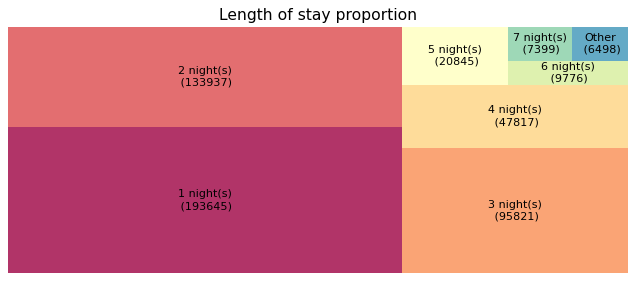

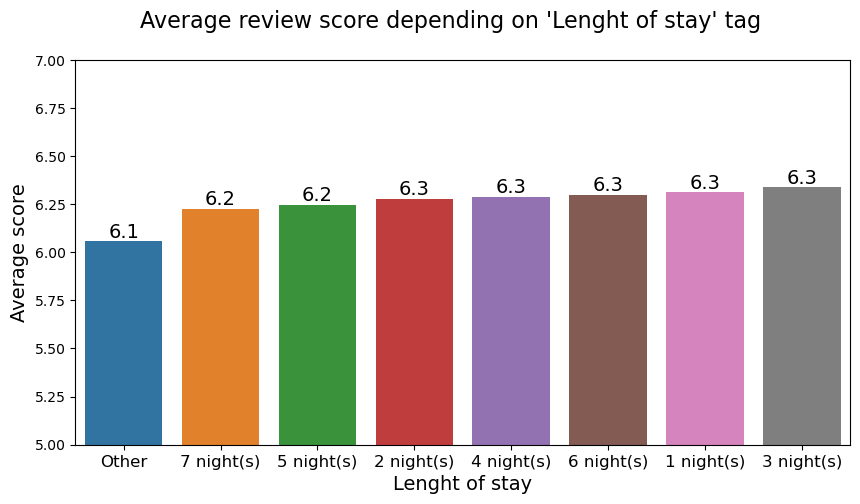

In [65]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'stay_length', 
                     'Length of stay proportion', size=[10, 4])

chart_score_vs_column(data, 'stay_length', 
                      'Average review score depending on \'Lenght of stay\' tag', 
                      'Lenght of stay', 
                      'Average score', 
                      size=[10, 5], ylim=[5, 7])

Лучшие оценки ставят постояльцы на 3 ночи. Наихудшие - проживающие более недели.

Tag 6. Room type

In [66]:
# Returns room type
def get_room_type(tags_list):
    for element in tags_list:
        if 'Room' in element:
            return element
    return 'Other'

data['room_type'] = data['tags_list'].apply(get_room_type)

data = reduce_categories_number(data, 'room_type', 7)

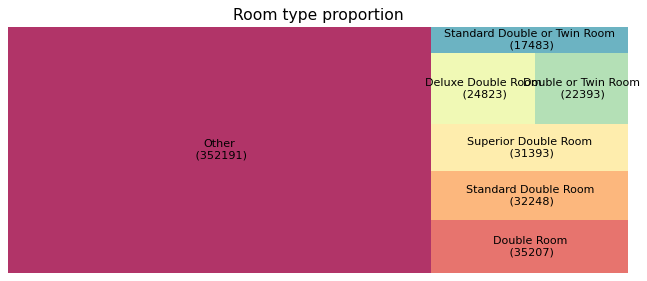

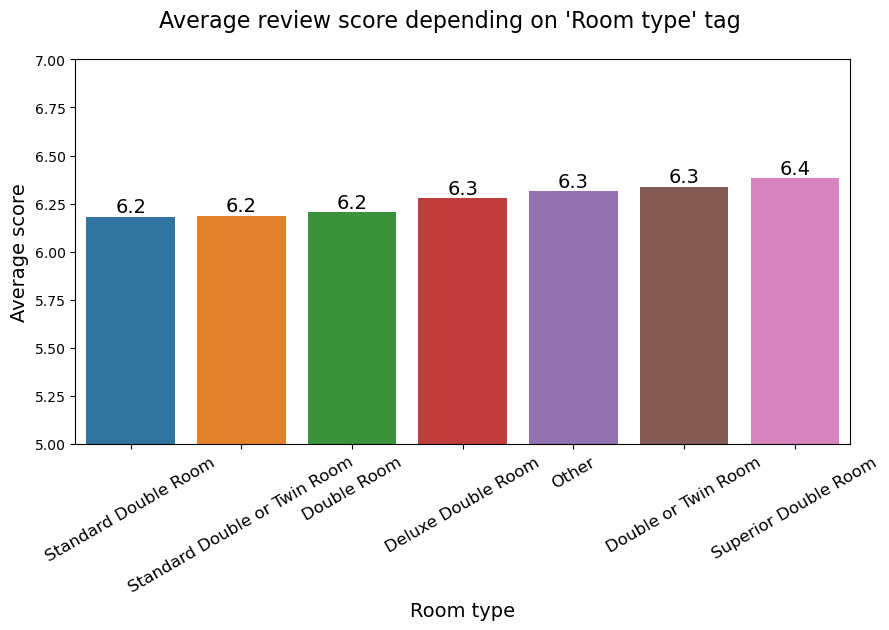

In [67]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'room_type', 
                     'Room type proportion', size=[10, 4])

chart_score_vs_column(data, 'room_type', 
                      'Average review score depending on \'Room type\' tag', 
                      'Room type', 
                      'Average score', 
                      size=[10, 5], ylim=[5, 7], xticks_rotation=30)

Некоторые наблюдения и выводы по тегам:

* Мы получили 6 типов информации из тегов:

   * с домашними животными или без них,
   * отзыв с мобильного устройства, тип поездки,
   * тип путешественника,
   * продолжительность пребывания и тип номера.

* Существует некоторая корреляция между информацией из тегов и нашей целевой переменной reviewer_score.
* Мы оставляем всю полученную информацию до последующего анализа ее важности для нашей модели.

Дата отзыва / Review date

Из review_date извлекаем год, месяц, дату и день недели.

In [68]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day'] = data['review_date'].dt.day
data['weekday'] = data['review_date'].dt.weekday + 1 # Monday = 1, ..., Sunday = 7

data = data.drop('review_date', axis=1)

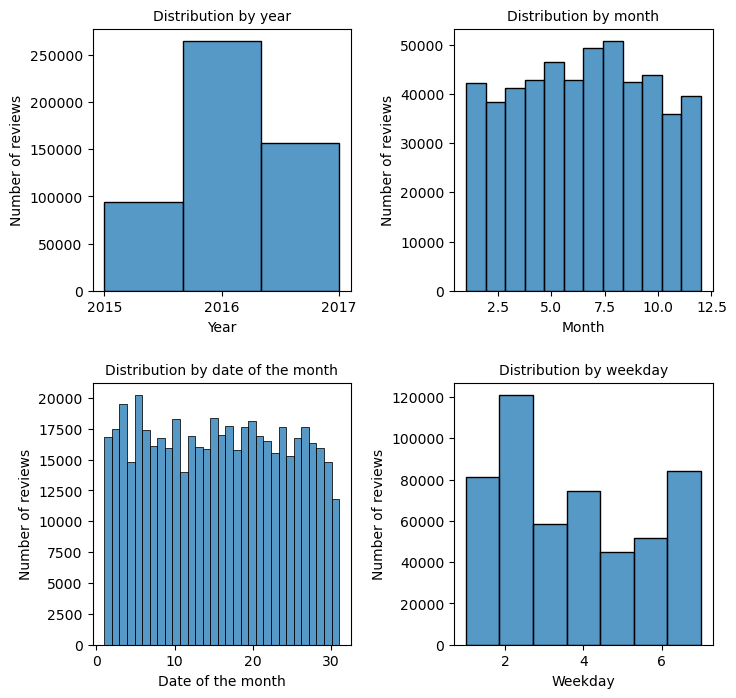

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
plt.subplots_adjust(hspace=.35, wspace=.4)

histplot1 = sns.histplot(data=data, x='year', bins=3, ax=axes[0,0])
histplot1.set_title('Distribution by year', fontsize=10)
histplot1.set_xlabel('Year')
histplot1.set_ylabel('Number of reviews')
histplot1.set_xticks([2015,2016,2017])

histplot2 = sns.histplot(data=data, x='month', bins=12, ax=axes[0,1])
histplot2.set_title('Distribution by month', fontsize=10)
histplot2.set_xlabel('Month')
histplot2.set_ylabel('Number of reviews')

histplot3 = sns.histplot(data=data, x='day', bins=31, ax=axes[1,0])
histplot3.set_title('Distribution by date of the month', fontsize=10)
histplot3.set_xlabel('Date of the month')
histplot3.set_ylabel('Number of reviews')

histplot3 = sns.histplot(data=data, x='weekday', bins=7, ax=axes[1,1])
histplot3.set_title('Distribution by weekday', fontsize=10)
histplot3.set_xlabel('Weekday')
histplot3.set_ylabel('Number of reviews');

Мы можем видеть некоторую связь между датами рецензирования и количеством отзывов, например, большинство отзывов пишется по вторникам и меньше всего по пятницам. Мы также видим, что большинство отзывов в нашем наборе данных относятся к 2016 году. Оставляем эту информацию в нашем наборе данных для будущего анализа.

Год / Year

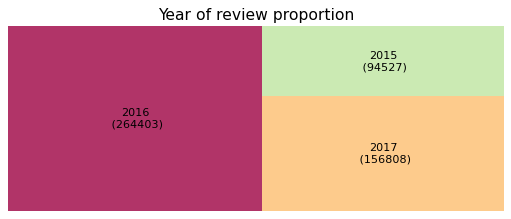

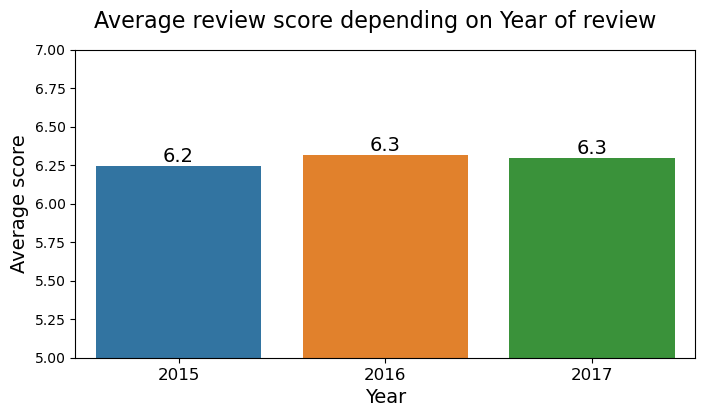

In [70]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'year', 
                     'Year of review proportion', size=[8, 3])

chart_score_vs_column(data, 'year', 
                      'Average review score depending on Year of review', 
                      'Year', 
                      'Average score', 
                      size=[8, 4], ylim=[5, 7])

Месяц / Month

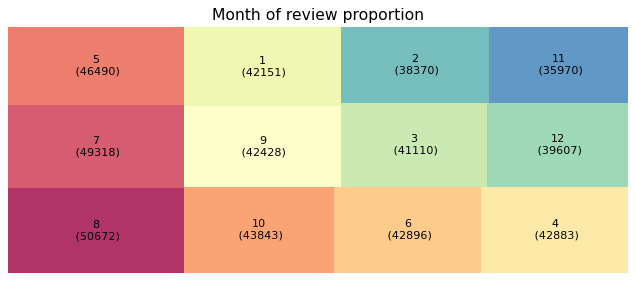

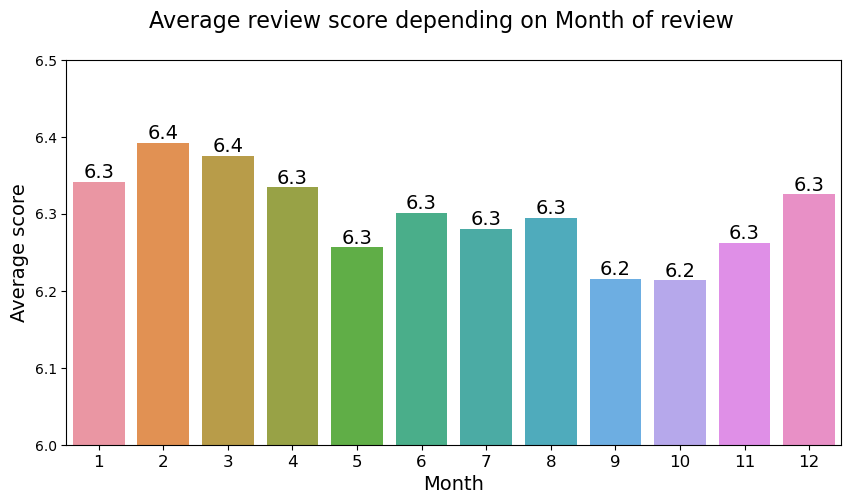

In [71]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'month', 
                     'Month of review proportion', size=[10, 4])

chart_score_vs_column(data, 'month', 
                      'Average review score depending on Month of review', 
                      'Month', 
                      'Average score', 
                      size=[10, 5], ylim=[6, 6.5])

Дата / Date

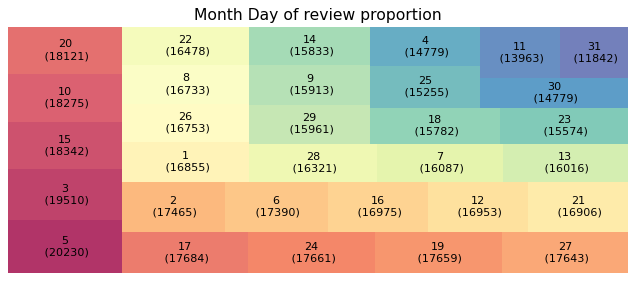

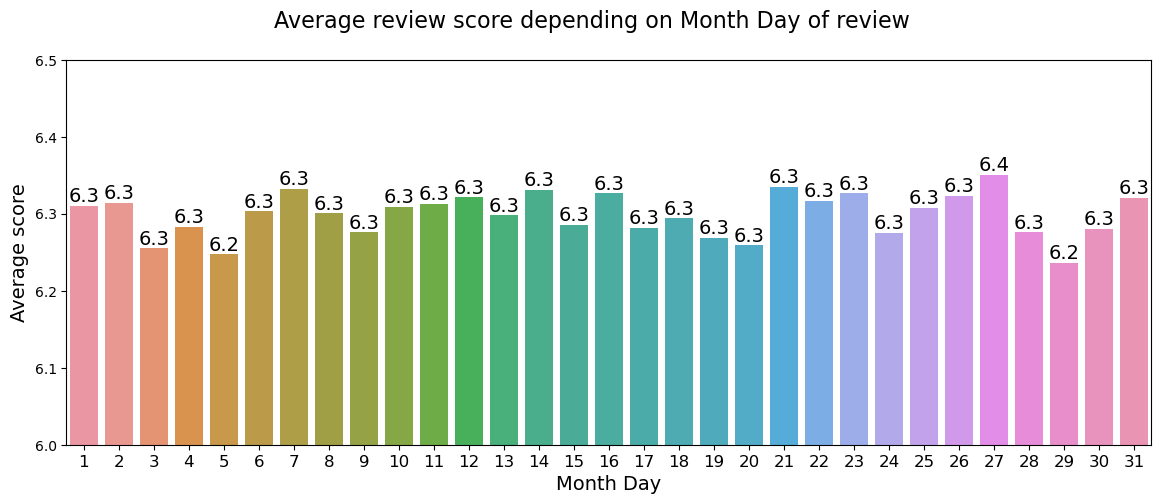

In [72]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'day', 
                     'Month Day of review proportion', size=[10, 4])

chart_score_vs_column(data, 'day', 
                      'Average review score depending on Month Day of review', 
                      'Month Day', 
                      'Average score', 
                      size=[14, 5], ylim=[6, 6.5])

День недели / Day of the week

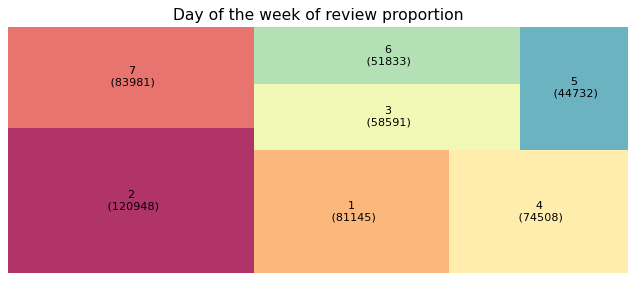

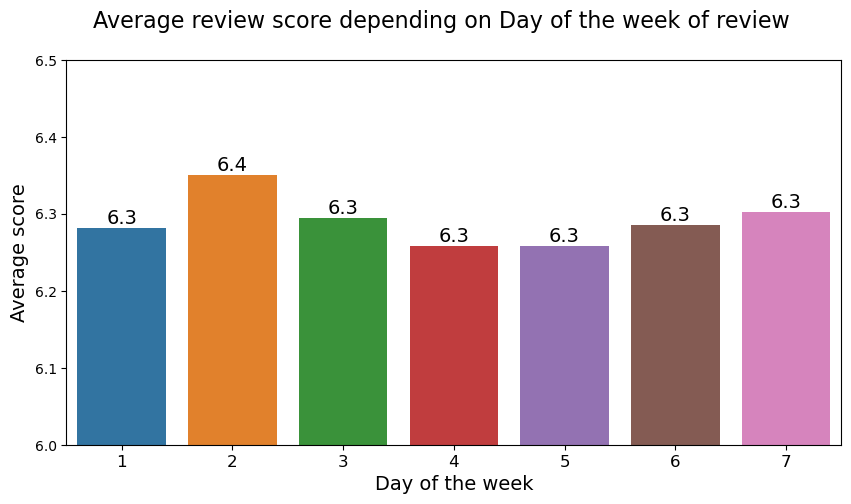

In [73]:
# Визуализация признака / Feature visualization

chart_column_treemap(data, 'weekday', 
                     'Day of the week of review proportion', size=[10, 4])

chart_score_vs_column(data, 'weekday', 
                      'Average review score depending on Day of the week of review', 
                      'Day of the week', 
                      'Average score', 
                      size=[10, 5], ylim=[6, 6.5])

Итог: некоторая связь между годом, месяцем, датой, днем недели и оценкой. Оставим полученную информацию и попробуем использовать ее в модели.

Интересно, что больше всего отзывов пишут по вторникам. Самые высокие оценки ставят также по вторникам.

Количество дней с даты отзыва / Days since review

Преобразуем в целое число.

In [74]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

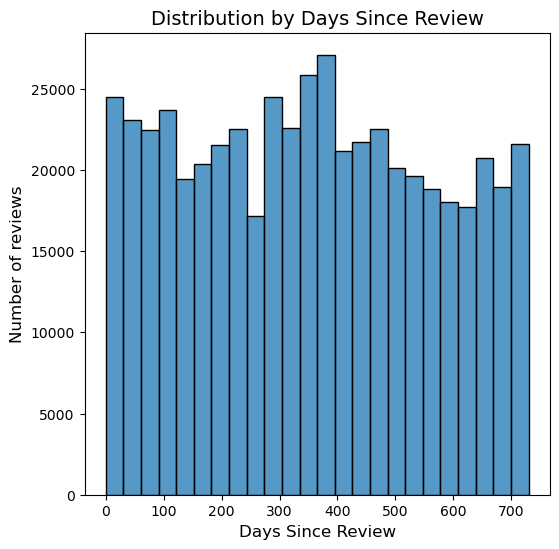

In [75]:
# Визуализация признака / Feature visualization

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
plt.subplots_adjust(hspace=.25)

histplot = sns.histplot(data=data, x='days_since_review', bins=24)
histplot.set_title('Distribution by Days Since Review', fontsize=14)
histplot.set_xlabel('Days Since Review', fontsize=12)
histplot.set_ylabel('Number of reviews', fontsize=12);

Столбцы связанные с отзывами / Review-related columns

Преобразование признаков 'negative_review', 'positive_review'

Осталось как то обработать 'negative_review','positive_review'.
Используем Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER

In [78]:
# удаляем начальные и конечные пробелы в признаке негативных отзывов
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())
data['negative_review'].value_counts().reset_index().head(25)

,index,negative_review
0,no negative,127890
1,nothing,21185
2,n a,1815
3,none,1501
4,,849
5,nothing really,656
6,small room,570
7,all good,545
8,breakfast,545
9,no complaints,523


In [79]:
# удаляем начальные и конечные пробелы в признаке позитивных отзывов
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip())
data['positive_review'].value_counts().reset_index().head(25)

,index,positive_review
0,no positive,35946
1,location,11945
2,everything,3314
3,nothing,1731
4,great location,1687
5,the location,1606
6,good location,1496
7,breakfast,795
8,friendly staff,733
9,excellent location,639


In [80]:
%%time

# корректируем явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

# добавим контекст, чтобы "No Negative" тонально нёс негативную окраску
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

CPU times: user 5min 24s, sys: 333 ms, total: 5min 24s
Wall time: 5min 25s


In [81]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

Преобразование признаков 'review_total_negative_word_counts', 'review_total_positive_word_counts'

Целевая переменная демонстрирует зависимость от обеих величин. Соединим оба признака в один, вычислив разницу количества слов в позитивной и негативной частях отзыва, предварительно нормализуем оба признака:

In [82]:
# кодируем исходный признак
data_ttl_pos_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(
    data[['review_total_positive_word_counts']])
data_ttl_neg_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(
    data[['review_total_negative_word_counts']])

# преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_ttl_pos_words_cnts_mm = pd.DataFrame(
    data_ttl_pos_words_cnts_mm, columns=['review_ttl_pos_word_cnts_norm'])
data_ttl_neg_words_cnts_mm = pd.DataFrame(
    data_ttl_neg_words_cnts_mm, columns=['review_ttl_neg_word_cnts_norm'])

# посмотреть результаты
# display(data_ttl_pos_words_cnts_mm, data_ttl_neg_words_cnts_mm)

# добавляем к основному датасету
data = pd.concat([data, data_ttl_pos_words_cnts_mm], axis=1)
data = pd.concat([data, data_ttl_neg_words_cnts_mm], axis=1)

# соединим эти показатели в один - разностный
data['review_ttl_word_cnts_diff_norm'] = data['review_ttl_pos_word_cnts_norm'] - \
    data['review_ttl_neg_word_cnts_norm']

# добавим флаг, который показывает преобладают ли позитивные слова 
# над негативными в размерностях соответствующих диапазонов
data['more_positive_words_flag'] = data['review_ttl_word_cnts_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0).astype('int8')

Также добавим долю одной из частей (второй показатель будет обратно пропорциональным):

In [83]:
# формируем новый дополнительный признак из числа основных
data['review_total_word_counts'] = data['review_total_positive_word_counts'] + \
    data['review_total_negative_word_counts']

# если общее количество слов равно 0, то считаем обе части равнозначными - по 0.5
data['review_positive_word_proportion'] = data.apply(
    lambda x: 0.5 if x['review_total_word_counts'] == 0 \
        else (x['review_total_positive_word_counts'] / x['review_total_word_counts']),
    axis=1)

# удаление вспомогательных дополнительных признаков
data.drop(['review_ttl_pos_word_cnts_norm', 
    'review_ttl_neg_word_cnts_norm', 
    'review_ttl_word_cnts_diff_norm',
    'review_total_word_counts'], axis = 1, inplace=True)

In [84]:
# проверка результата
data[['more_positive_words_flag', 'review_positive_word_proportion']]

,more_positive_words_flag,review_positive_word_proportion
0,1,0.571429
1,0,0.400000
2,0,0.000000
3,1,1.000000
4,1,0.833333
...,...,...
515733,1,1.000000
515734,1,1.000000
515735,0,0.425926
515736,1,1.000000


Преобразование признака 'total_number_of_reviews_reviewer_has_given'

In [85]:
# вычисляем долю рецензий данных рецензентом от общего числа отзывов в датасете
data['ratio_of_review'] = data['total_number_of_reviews_reviewer_has_given'] / \
    data['total_number_of_reviews']

# логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента
data['total_number_of_reviews_reviewer_has_given'] = data['total_number_of_reviews_reviewer_has_given'].apply(
    lambda x: np.log(x + 1))

In [86]:
# проверка результата
data['ratio_of_review']

0         0.003511
1         0.010287
2         0.034483
3         0.013180
4         0.001318
            ...   
515733    0.014228
515734    0.001912
515735    0.000289
515736    0.006648
515737    0.000349
Name: ratio_of_review, Length: 515738, dtype: float64

## 3. Очистка и выбор признаков

#### Очистка датасета от исходных (и более не требующихся) признаков

Подготовим датасет к очистке признаков, на которых модель обучаться не будет.

In [87]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [88]:
# создаем копию датафрейма (для повторного воспроизведения шагов с уже обработанными данными)
data_copy = data.__deepcopy__()

In [89]:
# # "включить машину времени для датафрейма"
# data = data_copy

In [90]:
# убираем нечисловые признаки, т.к. модель может обучаться только на числовых признаках
object_columns = [col for col in data.columns
    if ((data[col].dtypes == 'object') | \
        (data[col].dtype.name == 'category') | \
        (data[col].dtypes == 'datetime64[ns]'))]

# смотрим, что попадает под удаление
print(f'Удалению подлежит {len(object_columns)} столбцов с нечисловыми данными:')
object_columns

Удалению подлежит 17 столбцов с нечисловыми данными:


['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'country',
 'city',
 'tags_list',
 'trip_type',
 'traveller_type',
 'stay_length',
 'room_type',
 'neg_review_tokenized',
 'pos_review_tokenized',
 'neg_scores',
 'pos_scores']

In [91]:
# удаляем выбранные признаки по заданным критериям
data.drop(object_columns, axis = 1, inplace=True)

In [92]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   reviewer_score                              515738 non-null  float64
 7   days_since_review                           515738 non-null  int64  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

#### Анализ мультиколлинеарности

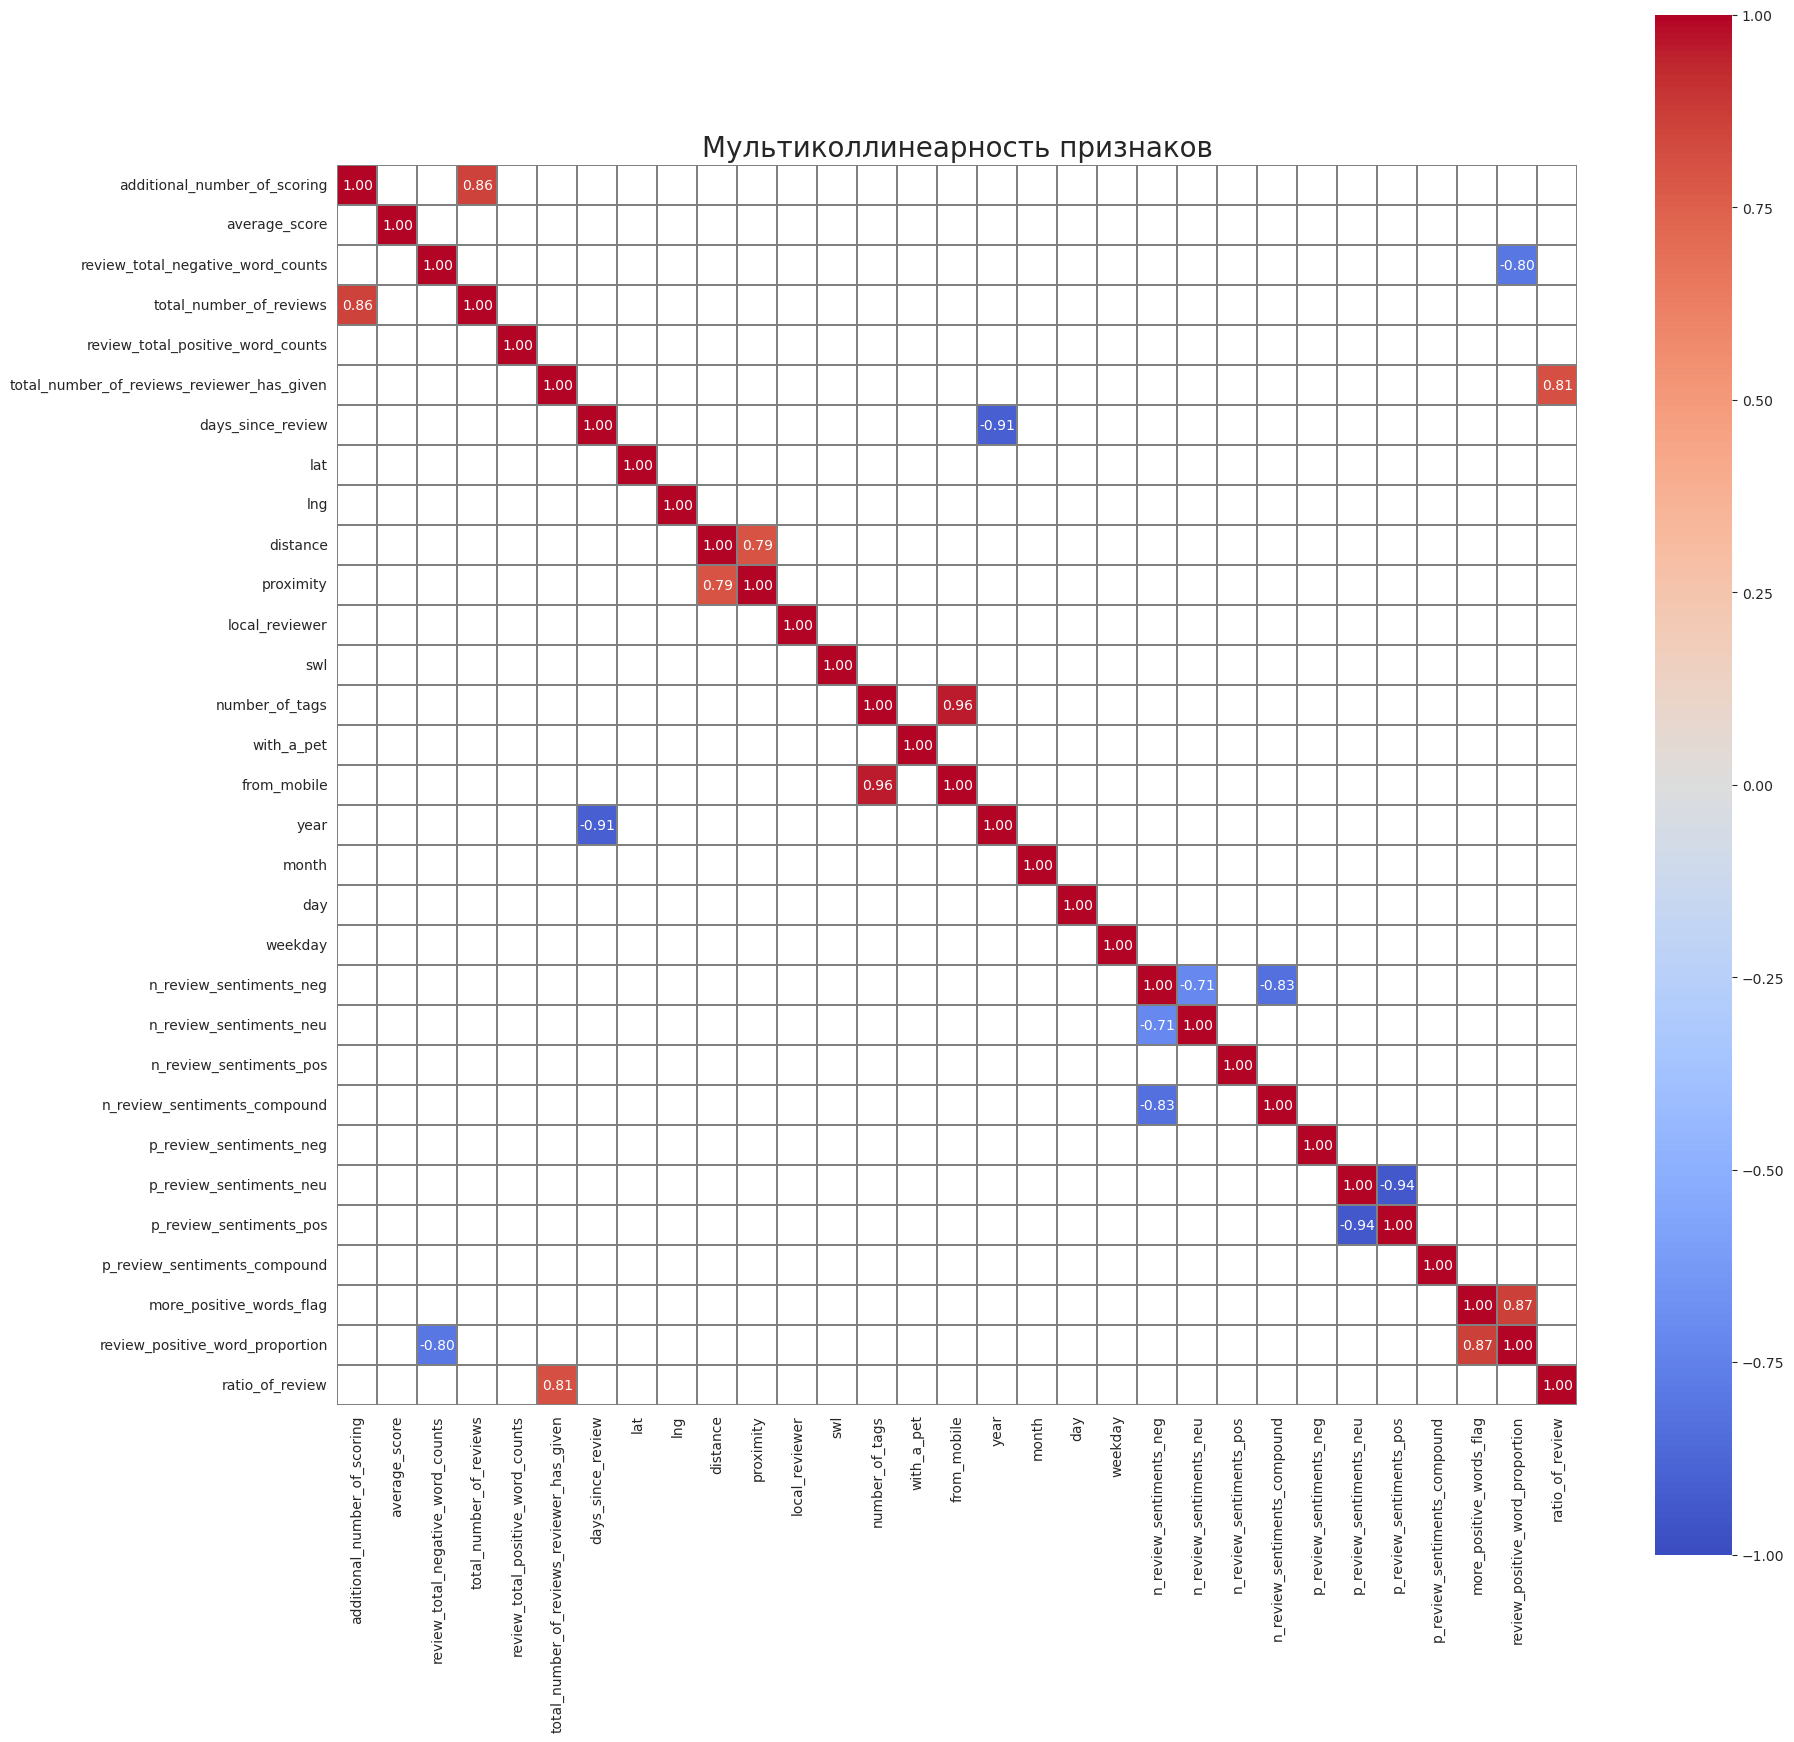

In [93]:
# строим тепловую корреляционную матрицу и анализируем данные на предмет наличия мультиколлинеарности
# используем метод Спирмана, т.к. у нас не только непрерывные переменные

# данные для построения графика
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
plt.subplots(figsize=(20, 20))

# график - тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок
ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

Исходя из представленной тепловой матрицы смело можно удалить:

* lat;
* lng;
Эти признаки ни на что не повлияют, а остальные стоит рассмотреть в разрезе оценки ANOVA и Хи-квадрат

#### Оценка значимости признаков

Для оценки значимости признаков будем использовать тесты:

* хи-квадрат - для категориальных,
* тест ANOVA - для числовых (непрерывных) признаков.

In [94]:
# разделим признаки на 2 группы - категориальные и числовые
data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lat', 'lng', 'sample', 'distance', 'proximity',
       'local_reviewer', 'swl', 'number_of_tags', 'with_a_pet', 'from_mobile',
       'year', 'month', 'day', 'weekday', 'n_review_sentiments_neg',
       'n_review_sentiments_neu', 'n_review_sentiments_pos',
       'n_review_sentiments_compound', 'p_review_sentiments_neg',
       'p_review_sentiments_neu', 'p_review_sentiments_pos',
       'p_review_sentiments_compound', 'more_positive_words_flag',
       'review_positive_word_proportion', 'ratio_of_review'],
      dtype='object')

In [95]:
# категориальные признаки
cat_cols = [
    'average_score',
    'reviewer_nationality_te', 
    'hotel_country_code', 
    'hotel_city_code', 
    'tag_from_mobile', 
    'tag_with_pet',
    'tag_leisure_trip', 
    'tag_reviewer_type', 
    'tag_count_nights', 
    'tag_view_room', 
    'tag_room_type', 
    'year_month_te', 
    'hotel_name_code', 
    'more_positive_words_flag'
]

# числовые (непрерывные) признаки
num_cols = [
    'additional_number_of_scoring', 
    'review_total_negative_word_counts', 
    'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given', 
    'total_number_of_reviews', 
    'days_since_review', 
    'tags_count', 
    'n_review_sentiments_neg', 'n_review_sentiments_neu',
    'n_review_sentiments_pos', 'n_review_sentiments_compound',
    'p_review_sentiments_neg', 'p_review_sentiments_neu',
    'p_review_sentiments_pos', 'p_review_sentiments_compound',
    'review_positive_word_proportion', 
    'ratio_of_review'
]

In [97]:
# задаём маску для отбора тренировочных значений
# БУДЕТ ДЕЙСТВОВАТЬ НА ВСЕ РАСЧЁТЫ
sample_mask = data['sample'] == 1

# разбиваем датасет на части, необходимые для оценки признаков
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = data[sample_mask].drop(['reviewer_score'], axis = 1)
y = data[sample_mask]['reviewer_score'].astype('int')

In [102]:
# функция построения тепловой матрицы корреляции для группы признаков
def show_corr_heatmap(columns_list, method='pearson', title_heat=None):
    """ Функция строит тепловую матрицу корреляции по переданным параметрам,
        на выходе - график, никакие значения не возвращаются

    Args:
        columns_list (list): список признаков, для которых строится матрица корреляции
        method (str, optional): расчётный метод корреляции. Defaults to 'pearson'.
        title_heat (str, optional): заголовок графика. Defaults to None.
    """
    _, ax_heat = plt.subplots(figsize=(15, 15))
    # данные для построения графика
    corr = data[columns_list].corr(method=method)
    
    # задаём срезовую маску, выводятся параметры по нижней диагонали
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # график - тепловая матрица
    sns.heatmap(
        corr,
        ax=ax_heat,
        vmin=-1, 
        vmax=1, 
        mask=mask,
        linewidths=0.1,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        square=True)
    
    # задаём заголовок и кегль начертания
    ax_heat.set_title(title_heat, fontsize=20)
    plt.show()

#### Оценка значимости категориальных признаков

In [106]:
# Функция для построения кореляционной диаграммы признаков
def chart_correlation_heatmap(df, 
                              columns, 
                              title, 
                              method='pearson', 
                              correlation_threshold=.6):
    """Построение корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    correlation_matrix = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix[correlation_matrix.abs() > correlation_threshold], 
                annot=True,
                annot_kws={"fontsize":9}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

In [107]:
# Разделяем признаки различных типов

# Категориальные - либо кодировать, либо удалить
categorical_columns = [
    'reviewer_nationality',
    'chain', 
    'country',
    'trip_type', 
    'traveller_type',
    'stay_length',
    'room_type'
]

# for col in categorical_columns:
#     data[col] = data[col].astype('category')

# Не цифровые, типа 'object', больше нам не нужны, можно удалить
object_columns = [
    'hotel_name',
    'negative_review',
    'positive_review',
    'neg_review_tokenized',
    'pos_review_tokenized',
    'tags',
    'hotel_address',
    'city',
    'tags_list',
    'sample'
]

# Признаки мешков слов
bow_columns = list(data.columns)[49:]

# Числовые признаки
numerical_columns = set(data.columns) - \
                    set(categorical_columns) - \
                    set(object_columns) - \
                    set(bow_columns)

/tmp/ipykernel_32/3247181421.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  correlation_matrix = df[columns].corr(method=method).abs()


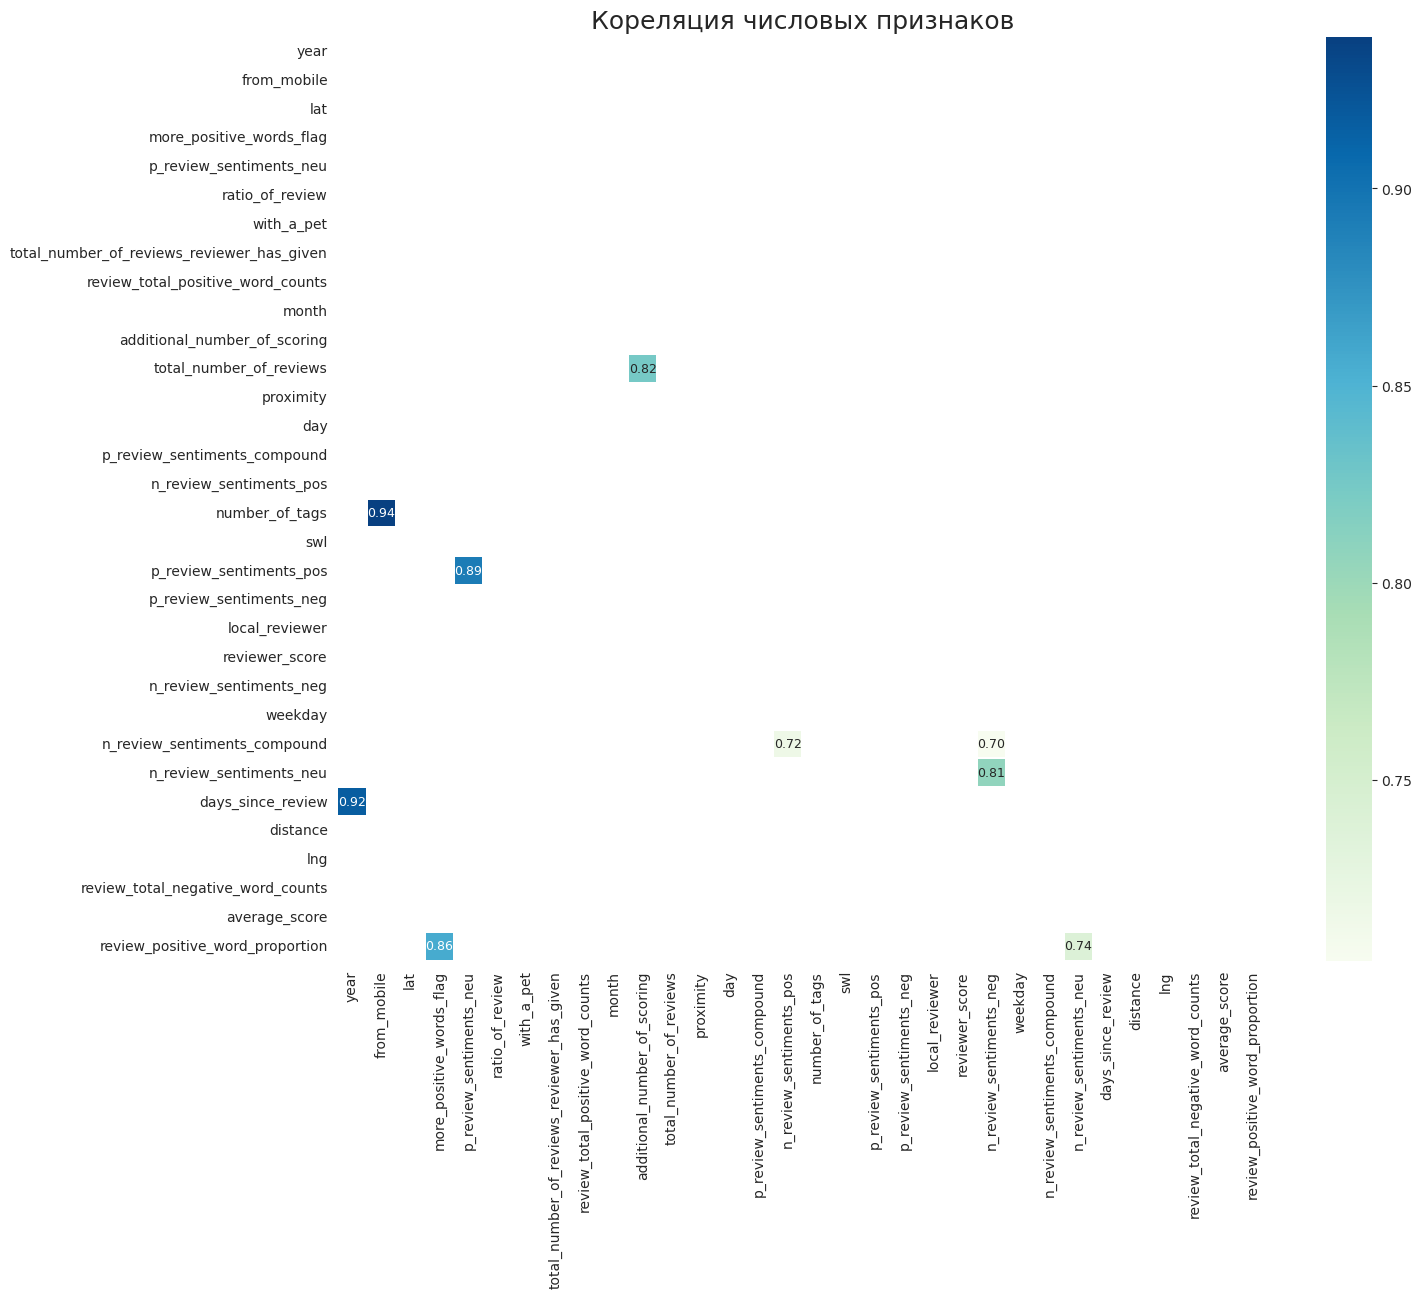

In [108]:
# sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
chart_correlation_heatmap(data, 
                          numerical_columns, 
                          'Кореляция числовых признаков',
                          correlation_threshold = .7)

In [109]:
# чтобы еще вывести в "копируемом" после формате, напишем следующие стоки кода

corr = data[numerical_columns].corr(method='pearson')
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr ind' }).\
     sort_values(by = 'Corr ind', ascending = False)
corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr ind'] > .7))].\
  iloc[0::2,:].reset_index(drop = True)

/tmp/ipykernel_32/2088242848.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  corr = data[numerical_columns].corr(method='pearson')


Наиболее высокая корреляция между признаками:


,feature 1,feature 2,Corr ind
0,from_mobile,number_of_tags,0.938510
1,year,days_since_review,0.917266
2,p_review_sentiments_neu,p_review_sentiments_pos,0.892166
3,more_positive_words_flag,review_positive_word_proportion,0.856651
4,total_number_of_reviews,additional_number_of_scoring,0.824884
5,n_review_sentiments_neg,n_review_sentiments_neu,0.807353
6,n_review_sentiments_neu,review_positive_word_proportion,0.739352
7,n_review_sentiments_pos,n_review_sentiments_compound,0.716871
8,n_review_sentiments_compound,n_review_sentiments_neg,0.704236


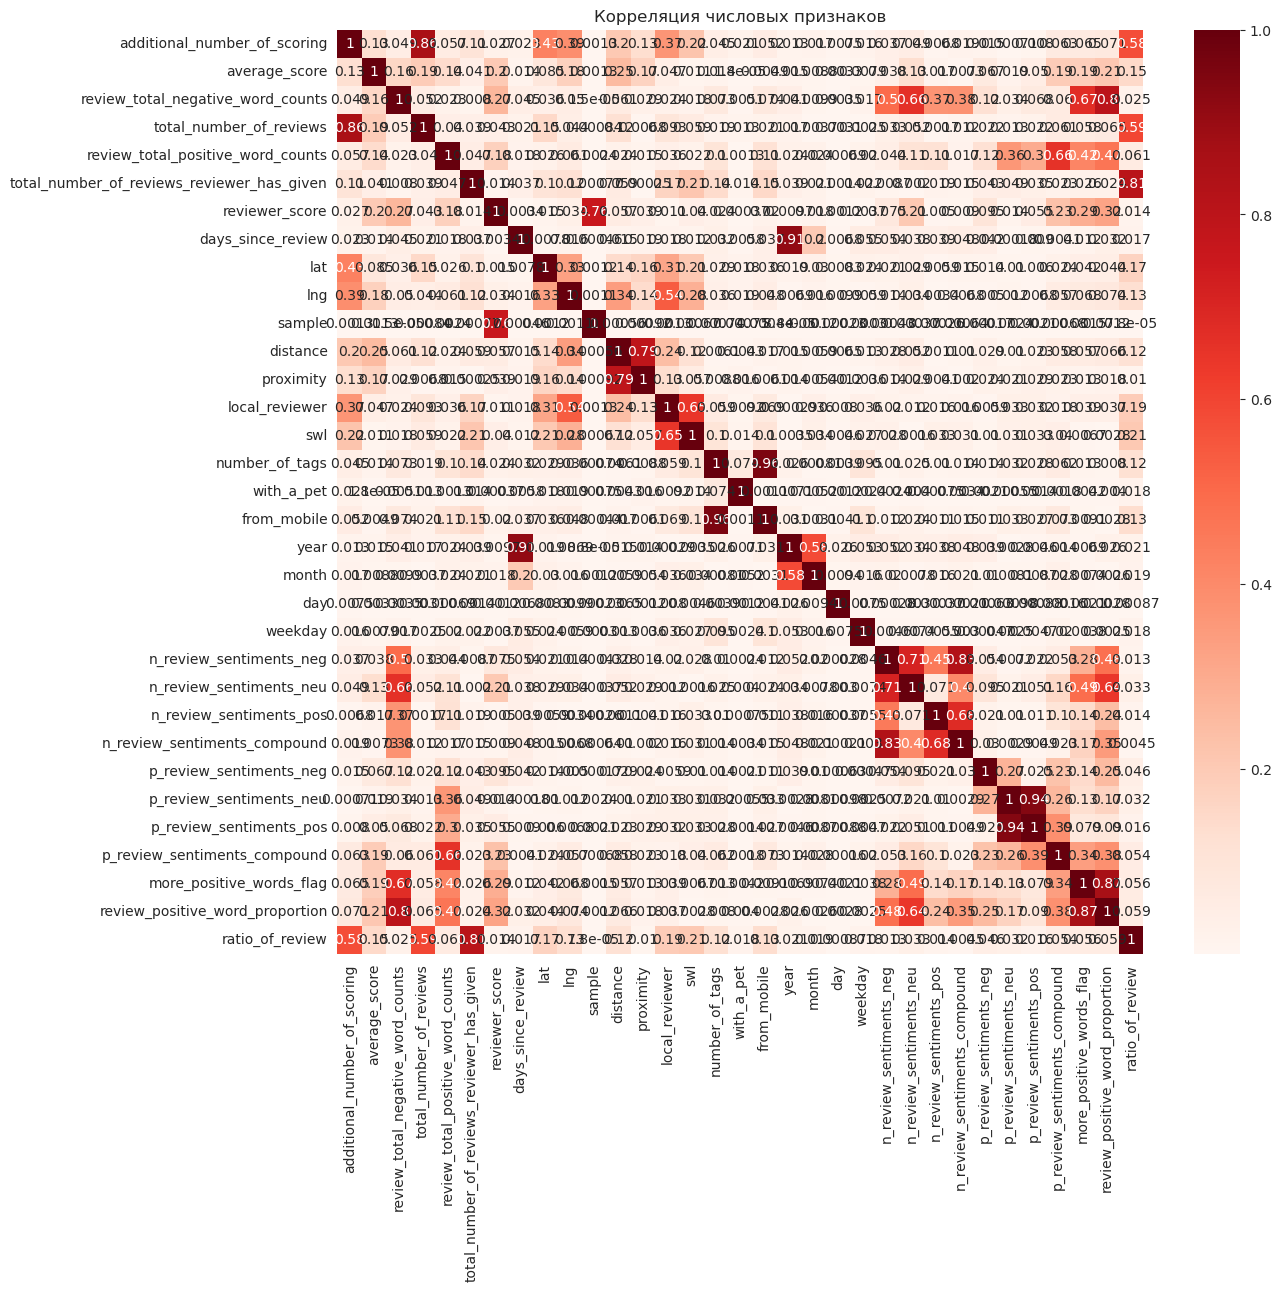

In [115]:
plt.figure(figsize=(13, 12))
heatmap = sns.heatmap(data=data.corr(method='spearman').abs(), annot=True, cmap='Reds')
heatmap.set_title('Корреляция числовых признаков')
plt.show()

### 4. Построение модели / Modelling

In [116]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [117]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [118]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386803, 32), (386803, 31), (309442, 31), (77361, 31))

In [119]:
# # Импортируем необходимые библиотеки:
# from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
# from sklearn import metrics # инструменты для оценки точности модели

In [120]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [121]:
%%time

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s


CPU times: user 18min 36s, sys: 4.61 s, total: 18min 40s
Wall time: 4min 52s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [122]:
# Округляем результат до десятых долей

for i in range(len(y_pred)):
    y_pred[i] = round(y_pred[i], 1)

y_pred[:10]

array([6.2, 7.7, 8.7, 6.6, 9.5, 7.4, 9.6, 9.3, 9.8, 9.6])

In [123]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test)
# метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную ошибку (в процентах) предсказанных значений от фактических
mae_forest_regr = metrics.mean_absolute_error(y_test, y_pred).round(8)
mape_forest_regr = (metrics.mean_absolute_percentage_error(y_test, y_pred) * 100).round(8)
print(f'MAE: {mae_forest_regr}\nMAPE: {mape_forest_regr}')

MAE: 0.85372862
MAPE: 12.11877261


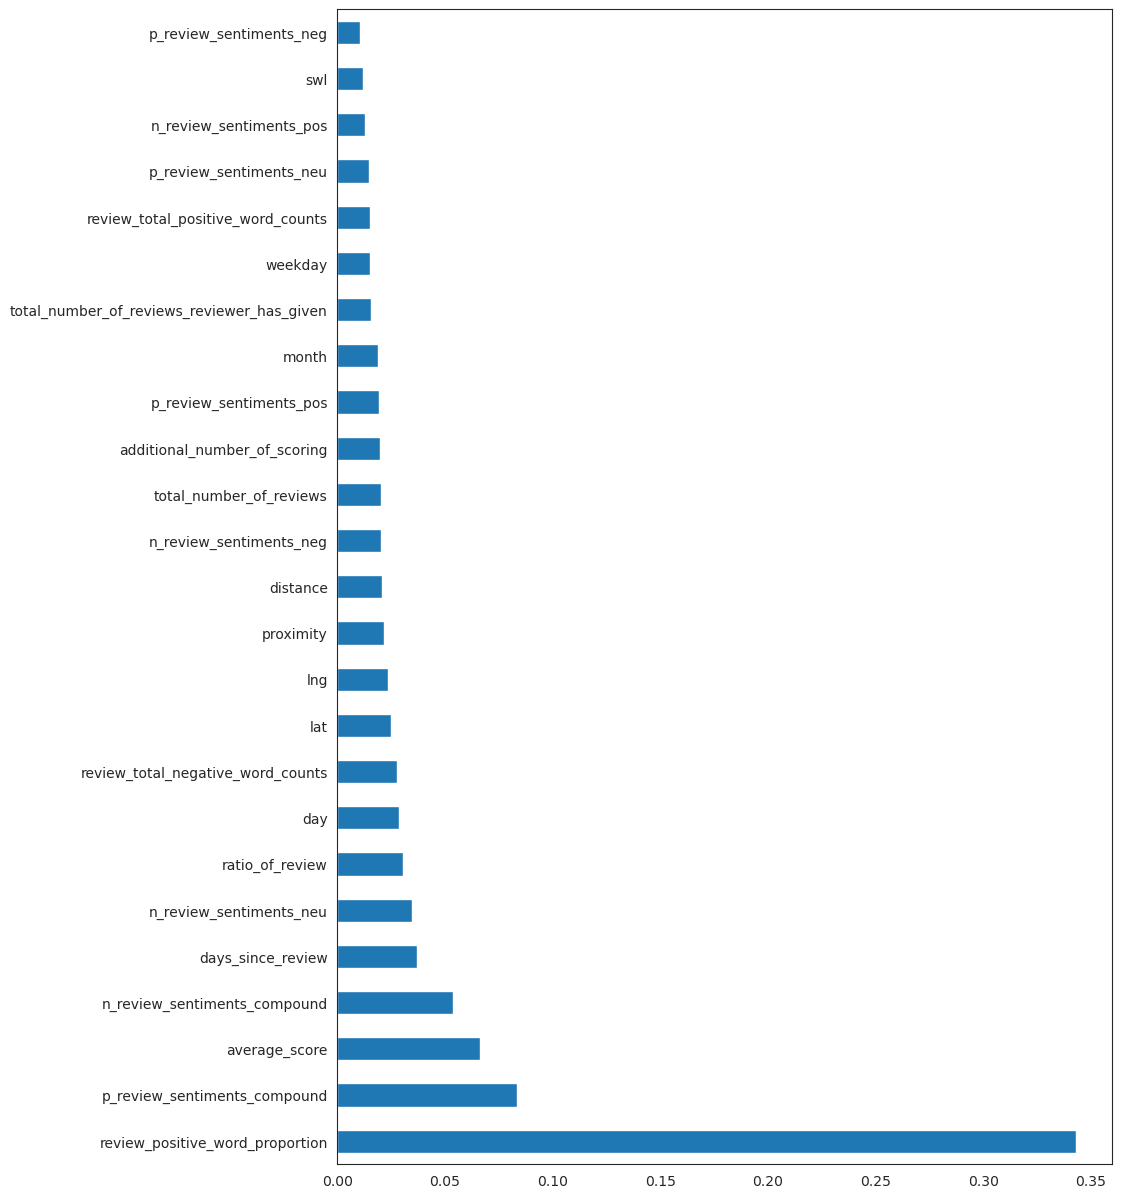

In [125]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh');

In [127]:
test_data = test_data.drop(['reviewer_score'], axis=1)

KeyError: "['reviewer_score'] not found in axis"

In [128]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [129]:
# Округляем результат до десятых долей

for i in range(len(predict_submission)):
    predict_submission[i] = round(predict_submission[i], 1)

predict_submission

array([8.4, 7.5, 8.1, ..., 8.2, 9.4, 7.2])

In [135]:
list(sample_submission)

['reviewer_score', 'id']

In [136]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.4,488440
1,7.5,274649
2,8.1,374688
3,9.9,404352
4,9.6,451596
5,9.0,302161
6,7.6,317079
7,7.5,13963
8,8.3,159785
9,7.5,195089
